In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, random_split
from BESTRq_classes.conformer import ConformerEncoder
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer
from compute_fft import compute_spectrogram, plot_spectrogram, mask_and_replace

## Defining classes and training functions

In [2]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [3]:
def pretrain(trainloader, validloader, model, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(model.encoder.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        for inputs, _ in trainloader:
            optimizer.zero_grad()
            if model.raw_signal:
                inputs = inputs.view(1, -1, 600).to(device)
            else:
                inputs = inputs.to(device)
            encoder_outs, labels = model(inputs, masking = True)
            loss = loss_function(encoder_outs, labels.view(-1))
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(encoder_outs, dim=1)
            if model.raw_signal:
                total += labels.size(1)
            else:
                total += labels.size(0)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                if model.raw_signal:
                    inputs = inputs.view(1, -1, 600).to(device)
                else:
                    inputs = inputs.to(device)
                encoder_outs, labels = model(inputs, masking = False)
                loss = loss_function(encoder_outs, labels.view(-1))
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.argmax(encoder_outs, dim=1)
                if model.raw_signal:
                    total += labels.size(1)
                else:
                    total += labels.size(0)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [4]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(600, torch.Size([175995, 600]))

In [5]:
class GRUPredictor(nn.Module):
    """GRUPredictor is a recurrent model. It takes as input a vector and predict
    the next one given past observations."""
    def __init__(self, input_dim=600, hidden_dim=50, nstack = 3, dropout=0):
        super(GRUPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout
        self.gru = nn.GRU(input_size=input_dim, hidden_size = hidden_dim,  num_layers = nstack)
        self.linear = nn.Linear(in_features = hidden_dim, out_features = 200)
        self.drop = nn.Dropout(p = dropout)
    def init_hidden(self, bsz):
        # This function is given: understand it.
        self.h = th.zeros(self.nstack, bsz, self.hidden_dim)

    def forward(self, inputs, h0=None):
        if h0 == None:
          h0 = self.init_hidden(inputs.shape[0])
        hidden, h0 = self.gru(inputs, h0)
        out = self.drop(hidden)
        out = self.linear(hidden)
        return out

In [19]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_dim=600, hidden_dim=100, nstack=2, dropout=0, codebook_size = 50, embedding_dim = 50):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout
        # LSTM layer
        self.lstm_stack = nn.ModuleList([
            nn.LSTM(input_size=input_dim if i == 0 else 2*hidden_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional= True,
            dropout=dropout if i < nstack - 1 else 0)  # Apply dropout only between layers
        for i in range(nstack)])


        # Linear layers for attention
        self.attention_linear = nn.Linear(2*hidden_dim, 1)
        self.context_linear = nn.Linear(2*hidden_dim, hidden_dim)

        # Final linear layer
        self.linear = nn.Linear(hidden_dim, codebook_size)

        # Dropout layer
        self.drop = nn.Dropout(p=dropout)


    def init_hidden(self, bsz):
        # Initialize hidden state for LSTM
        return (th.zeros(2, bsz, self.hidden_dim),
            th.zeros(2, bsz, self.hidden_dim))


    def forward(self, inputs, h0=None):
        if h0 is None:
            (h0, c0) = self.init_hidden(inputs.size(2))  # Use size(1) to get the batch size

        h, c  = h0[0:2, :, :].to(device), c0[0:2, :, :].to(device)

        inputs = inputs.permute(1,2, 0)
        # LSTM forward pass
        for i in range(self.nstack):


            inputs, (h,c) = self.lstm_stack[i](inputs, (h, c))
            inputs = self.drop(inputs)


        # Compute attention weights
        attention_weights = F.softmax(self.attention_linear(inputs), dim=0)

        # Apply attention to LSTM output
        attention_applied = th.sum(attention_weights * inputs, dim=0)

        # Compute context vector
        context = self.context_linear(attention_applied)

        context = F.relu(context)

        # Apply dropout
        out = self.drop(context)

        #Linear layer
        out = self.linear(out)


        #Softmax layer
        out = F.softmax(out, dim= 1)

        return out


In [6]:
def train_decoder(trainloader, validloader, encoder, decoder, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(encoder.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        encoder.eval()
        decoder.train()
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels = inputs.view(1, -1, 600).to(device), labels.to(device)
            with th.no_grad():
                encoder_outs = encoder(inputs)
            decoder_outs = decoder(encoder_outs.view(1, -1, 70))
            loss = loss_function(decoder_outs.view(-1, 6), labels.view(-1))
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(decoder_outs, dim=2)
            total += labels.size(0)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        decoder.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs, labels = inputs.view(1, -1, 600).to(device), labels.to(device)
                encoder_outs = encoder(inputs)
                decoder_outs = decoder(encoder_outs.view(1, -1, 70))

                loss = loss_function(decoder_outs.view(-1, 6), labels.view(-1))
                epoch_valid_loss += loss.item()
                # Compute accuracy
                predicted = th.argmax(decoder_outs, dim=2)
                total += labels.size(0)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

## First overview on raw signals

In [231]:
device = 'cpu'
tmp = RandomProjectionQuantizer(input_dim= 600, quantizer_dim= 100, codebook_size= 200,random_state= 2673834267383, device = device)
input_size = (175995, 600)
mask_time_indices = th.ones(input_size[0], input_size[1], dtype=th.bool, device= device).to(device)
mask_time_indices = mask_time_indices.view(-1, input_size[1]).unsqueeze(0)
xtrain_batched = xtrain.unsqueeze(0).to(device)
results  = tmp(xtrain_batched, raw_signal = True)
results.unique()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

/Users/constouille/Library/Caches/pypoetry/virtualenvs/dl-sleep-project-wfnrCJ-y-py3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Text(0.5, 1.0, 'Visualisation du masque')

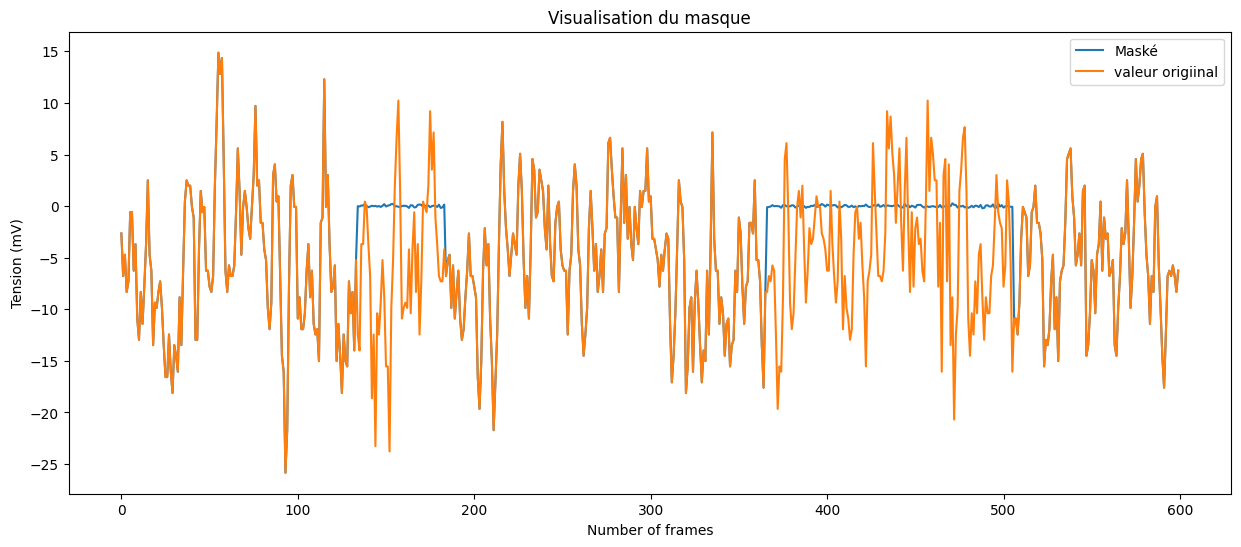

In [232]:
#Viz of the mask
model = BestRqFramework(encoder= AttentionLSTM(dropout = 0.1, hidden_dim = 150, nstack= 2),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=50,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=1,
                        batch_size=200)

inputs = xtrain[:200].to(device).view(-1, 200, 600)

masked_values,_ = model.masking(inputs)


plt.figure(figsize=(15,6))
for i in range(1):
    plt.plot(masked_values[0,i,:].cpu().detach().numpy(), label = 'Maské')
    plt.plot(inputs[0, i ,:].cpu().detach().numpy(), label ='valeur origiinal')
plt.legend()
plt.xlabel('Number of frames')
plt.ylabel('Tension (mV)')
plt.title('Visualisation du masque')

### Training the encoder

In [21]:
device = th.device('mps')

encoder = AttentionLSTM(dropout= 0.2, hidden_dim = 150, codebook_size= 70, nstack = 2, input_dim= 1)

model = BestRqFramework(encoder= encoder,
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=200,
                        num_code_books= 70,
                        mask_time= 50,
                        stride_time=1,
                        random_state=6618181,
                        mask_prob=0.01,
                        batch_size=400,
                        device = device)


inputs = xtrain[:200].to(device).view(-1, 200, 600)
    # `(batch size)` Number of available time steps per batch
input_lengths = th.tensor([200, 871, 389, 487]).to(device)

input_values, idx = model(inputs, masking = False)

input_values, idx

(tensor([[0.0132, 0.0137, 0.0147,  ..., 0.0148, 0.0146, 0.0136],
         [0.0130, 0.0135, 0.0146,  ..., 0.0150, 0.0148, 0.0137],
         [0.0133, 0.0135, 0.0148,  ..., 0.0148, 0.0147, 0.0137],
         ...,
         [0.0132, 0.0134, 0.0148,  ..., 0.0148, 0.0147, 0.0133],
         [0.0131, 0.0137, 0.0149,  ..., 0.0147, 0.0148, 0.0138],
         [0.0129, 0.0134, 0.0146,  ..., 0.0148, 0.0145, 0.0136]],
        device='mps:0', grad_fn=<SoftmaxBackward0>),
 tensor([[36, 26, 53, 26, 13, 17, 17, 13, 67, 53,  3, 13, 36, 36, 36,  3, 25,  8,
          13, 32, 61, 52,  8, 17, 13, 23, 17, 13, 57, 52, 13, 67, 36,  8, 13, 23,
          49, 51, 17, 22, 13, 10, 38, 59, 13, 57, 67, 23, 49, 13, 13, 18, 51, 53,
          29, 13, 27, 67, 23,  8, 13, 22,  1,  8, 13,  3, 27, 68, 15, 19, 17, 36,
          23, 18, 67, 22,  5, 67, 23, 22, 27, 19, 61, 67, 13, 13, 18, 23, 57,  8,
          36, 68, 17, 36, 17, 21, 25, 43, 13, 67, 19, 23, 10, 13, 13, 67, 36, 57,
          53, 48, 54, 17, 19, 49, 13, 17, 13, 17, 

Tried doing with hidden_dim = 200, mask_prob = 0.3, epochs = 100 but signs of overfitting appeared for about 30 epochs

In [23]:
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
dataset_t = TensorDataset(xtrain, ytrain)
dataset_size = len(dataset_t)
half_dataset_size = dataset_size // 2
dataset_t1, dataset_t2 = random_split(dataset_t,  [half_dataset_size, dataset_size - half_dataset_size])
train_loader = DataLoader(dataset_t2, batch_size= 500, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
dataset_size = len(dataset_v)
half_dataset_size = dataset_size // 2
dataset_v1, dataset_v2 = random_split(dataset_v,  [half_dataset_size, dataset_size - half_dataset_size])
valid_loader = DataLoader(dataset_v2, batch_size= 500, shuffle=True)
train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain(trainloader= train_loader, validloader= valid_loader, model = model, epochs= 100, device = device, lr = 1e-3)

  0%|          | 0/100 [00:06<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 8.29 GB, other allocations: 34.31 MB, max allowed: 9.07 GB). Tried to allocate 1.34 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

Text(0.5, 0.98, 'Attention-BiLSTM with codebook_size = 70 and hiden_dim = 50 and less masking')

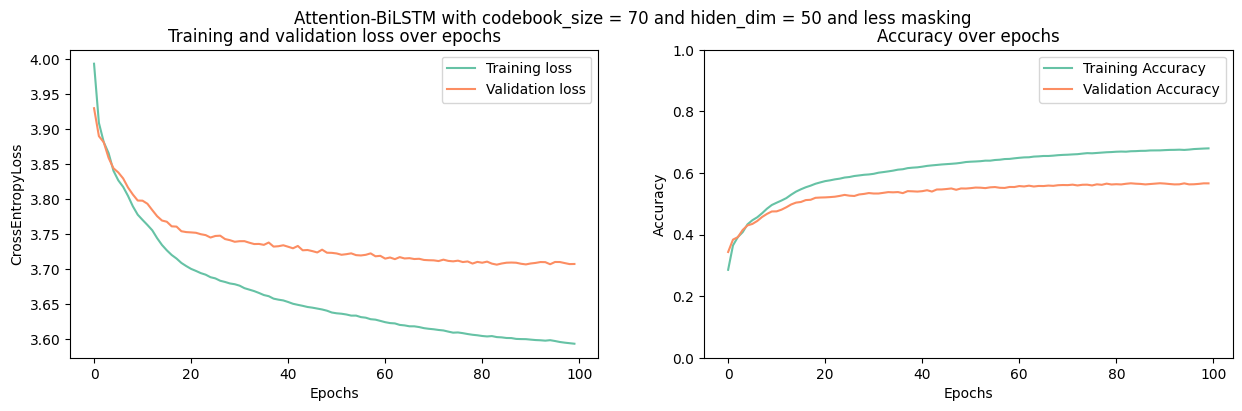

In [130]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('Attention-BiLSTM with codebook_size = 70 and hiden_dim = 50 and less masking')

In [278]:
## Saving the model
with open('models/BestRqEncoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [111]:
pred, label  = model(xtrain[1].view(1,1,-1))
th.argmax(pred)

tensor(24, device='mps:0')

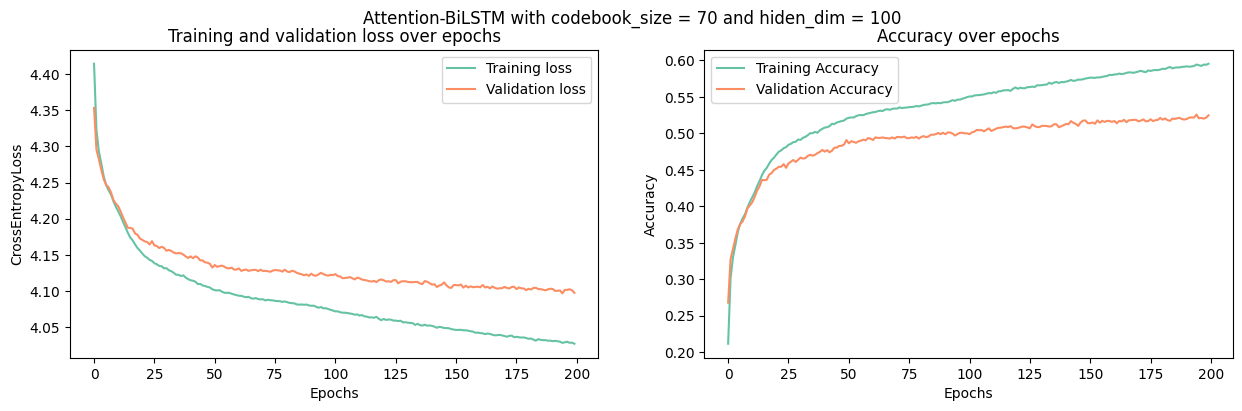

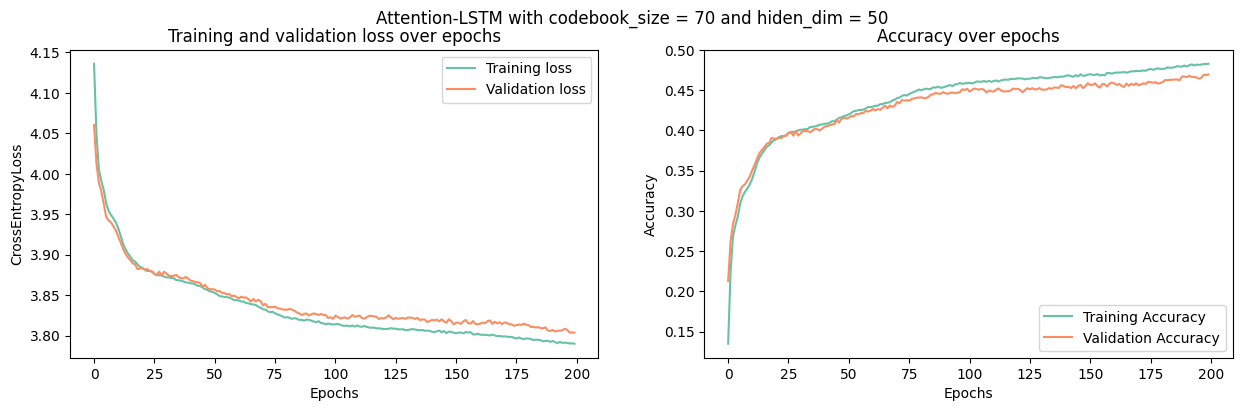

There is some overfitting where the training data is learned in a more efficient way than validation data. (Masking probability here was very high so the LSTM had trouble learning the noise)


### Training the decoder

In [163]:
decoder = nn.Conv2d(70, 32, kernel_size=3, stride=1, padding=1),
nn.Upsample(scale_factor=2, mode="nearest"),
nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
nn.GELU(),
nn.Upsample(scale_factor=2, mode="nearest"),
nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1))

In [144]:
with open('models/BestRqEncoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [166]:
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
dataset_t = TensorDataset(xtrain, ytrain)
dataset_size = len(dataset_t)
half_dataset_size = dataset_size // 2
dataset_t1, dataset_t2 = random_split(dataset_t,  [half_dataset_size, dataset_size - half_dataset_size])
train_loader = DataLoader(dataset_t2, batch_size= 500, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
dataset_size = len(dataset_v)
half_dataset_size = dataset_size // 2
dataset_v1, dataset_v2 = random_split(dataset_v,  [half_dataset_size, dataset_size - half_dataset_size])
valid_loader = DataLoader(dataset_v2, batch_size= 500, shuffle=True)

In [175]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train_decoder(trainloader= train_loader, validloader= valid_loader, encoder= encoder, decoder= decoder, device= device, lr = 1e-5)

 10%|█         | 1/10 [00:03<00:28,  3.16s/it]

Epoch 1/10, Train Loss: 1.793897694484754, Validation Loss: 1.7938536763191224, Training Accuracy: 0.07926316507193346, Validation Accuracy: 0.07688359679737221


 20%|██        | 2/10 [00:05<00:23,  2.93s/it]

Epoch 2/10, Train Loss: 1.793897657231851, Validation Loss: 1.7937907993793487, Training Accuracy: 0.07926316507193346, Validation Accuracy: 0.07688359679737221


 30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Epoch 3/10, Train Loss: 1.7938976971940561, Validation Loss: 1.7938562095165254, Training Accuracy: 0.07926316507193346, Validation Accuracy: 0.07688359679737221


 30%|███       | 3/10 [00:09<00:22,  3.17s/it]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('Encoder + Decoder')

## Trying with spectrogram

In [138]:

class AttentionLSTM_spec(nn.Module):
    def __init__(self, input_dim=31, hidden_dim=100, nstack=2, dropout=0, codebook_size=50,  conv_channels=128, conv_kernel_size=3):
        super(AttentionLSTM_spec, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout

        # Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=conv_channels, kernel_size=conv_kernel_size, padding=1)

        # Batch normalization layer
        self.batchnorm = nn.BatchNorm1d(conv_channels)

        # Max pooling layer
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=conv_channels, hidden_size=hidden_dim, num_layers=nstack, bidirectional=True)

        # Linear layers for attention
        self.attention_linear = nn.Linear(2 * hidden_dim, 1)
        self.context_linear = nn.Linear(2 * hidden_dim, hidden_dim)

        # Final linear layer
        self.linear = nn.Linear(2*hidden_dim, codebook_size)

        # Dropout layer
        self.drop = nn.Dropout(p=dropout)

    def init_hidden(self, bsz):
        # Initialize hidden state for LSTM
        return (th.zeros(2 * self.nstack, bsz, self.hidden_dim),
                th.zeros(2 * self.nstack, bsz, self.hidden_dim))

    def forward(self, inputs, h0=None):
        inputs = inputs.permute(0,2,1)
        if h0 is None:
            (h0, c0) = self.init_hidden(100)  # Use size(1) to get the batch size

        h0, c0 = h0.to(inputs.device), c0.to(inputs.device)

        #Convolutional layer
        conv_output = self.conv1d(inputs)

        # Apply batch normalization
        conv_output = self.batchnorm(conv_output)

        # Apply max pooling
        conv_output = self.maxpool(conv_output)


        # LSTM forward pass
        lstm_output, _ = self.lstm(conv_output.permute(0,2,1), (h0, c0))



        context = F.relu(lstm_output)

        # Apply dropout
        out = self.drop(context)

        # Linear layer
        out = self.linear(out)

        # Softmax layer
        out = F.softmax(out, dim=1)

        return out

In [177]:
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain, xvalid = compute_spectrogram(xtrain, n_fft = 400, window=th.hann_window(400)),compute_spectrogram(xvalid,  n_fft = 400, window=th.hann_window(400))
dataset_t = TensorDataset(xtrain, ytrain)
dataset_size = len(dataset_t)
half_dataset_size = dataset_size // 2
dataset_t1, dataset_t2 = random_split(dataset_t,  [half_dataset_size, dataset_size - half_dataset_size])
train_loader = DataLoader(dataset_t1, batch_size= 500, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
dataset_size = len(dataset_v)
half_dataset_size = dataset_size // 2
dataset_v1, dataset_v2 = random_split(dataset_v,  [half_dataset_size, dataset_size - half_dataset_size])
valid_loader = DataLoader(dataset_v1, batch_size= 500, shuffle=True)

In [220]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder_spec = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.GELU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.GroupNorm(4, 32, affine=False),
            nn.Conv2d(32, 70, kernel_size=1)
        )
        self.linear = nn.Linear(50*70*7, 200)

    def forward(self, x):
        x = x.unsqueeze(1)
        shape = x.shape
        x = self.encoder_spec(x)
        x = x.flatten().view(shape[0], -1)
        x = self.linear(x)
        return  x

In [221]:
encoder_spec = Encoder()
def train(trainloader, validloader, model, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels  = inputs.to(device), labels.to(device)
            encoder_outs = model(inputs)
            loss = loss_function(encoder_outs, labels.view(-1).long())
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(encoder_outs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs, labels  = inputs.to(device), labels.to(device)
                encoder_outs = model(inputs)
                loss = loss_function(encoder_outs, labels.view(-1).long())
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.argmax(encoder_outs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [222]:
device = 'cpu'
model = BestRqFramework(encoder= encoder_spec,
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=201,
                        encoder_hidden_size=150,
                        num_code_books= 70,
                        mask_time= 3,
                        stride_time=1,
                        random_state=6618181,
                        mask_prob=0.01,
                        batch_size=400,
                        raw_signal= False,
                        device = device,
                        input_quantizer_dim = 201*31)

In [225]:
train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain(trainloader = train_loader, validloader = valid_loader, model = model, device = device, lr = 1e-2, epochs = 10)

 10%|█         | 1/10 [03:20<30:06, 200.69s/it]

Epoch 1/10, Train Loss: 12.980548524043776, Validation Loss: 11.740755701065064, Training Accuracy: 0.1615168698932918, Validation Accuracy: 0.15735988503387394


 20%|██        | 2/10 [06:41<26:47, 200.91s/it]

Epoch 2/10, Train Loss: 9.191975065252997, Validation Loss: 2.8639765620231628, Training Accuracy: 0.17423321249588053, Validation Accuracy: 0.2138164647916239


 30%|███       | 3/10 [09:57<23:11, 198.73s/it]

Epoch 3/10, Train Loss: 2.3269098035313864, Validation Loss: 2.3102395296096803, Training Accuracy: 0.28515744854938235, Validation Accuracy: 0.27776637240812974


 40%|████      | 4/10 [13:04<19:23, 193.89s/it]

Epoch 4/10, Train Loss: 10.506959602236748, Validation Loss: 23.848193550109862, Training Accuracy: 0.22591679261793016, Validation Accuracy: 0.2205912543625539


 50%|█████     | 5/10 [17:49<18:53, 226.76s/it]

Epoch 5/10, Train Loss: 14.60810527070002, Validation Loss: 5.622065782546997, Training Accuracy: 0.17691512210643545, Validation Accuracy: 0.2647300349004311


 60%|██████    | 6/10 [21:09<14:31, 217.85s/it]

Epoch 6/10, Train Loss: 3.3201147385618905, Validation Loss: 2.3650715351104736, Training Accuracy: 0.2456561019125652, Validation Accuracy: 0.28248819544241427


 70%|███████   | 7/10 [24:32<10:38, 212.89s/it]

Epoch 7/10, Train Loss: 3.3100637034936384, Validation Loss: 2.3498543381690977, Training Accuracy: 0.2590542859415662, Validation Accuracy: 0.28084582221309795


 70%|███████   | 7/10 [25:24<10:53, 217.76s/it]


KeyboardInterrupt: 

In [85]:
for inputs, labels in train_loader:
    mask, a = mask_and_replace(inputs, mask_prob = 0.1, mask_time = 3, number_of_mask=4, device = device)

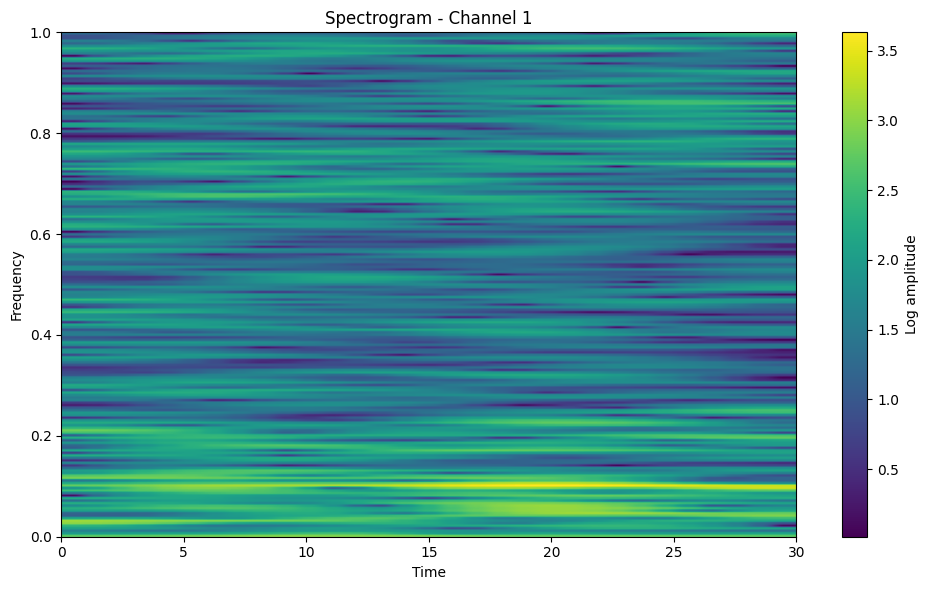

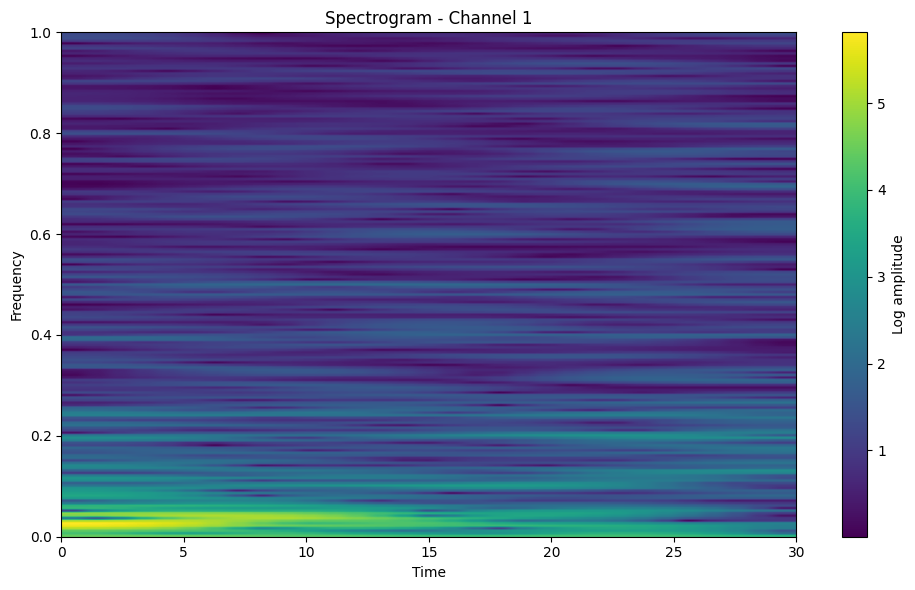

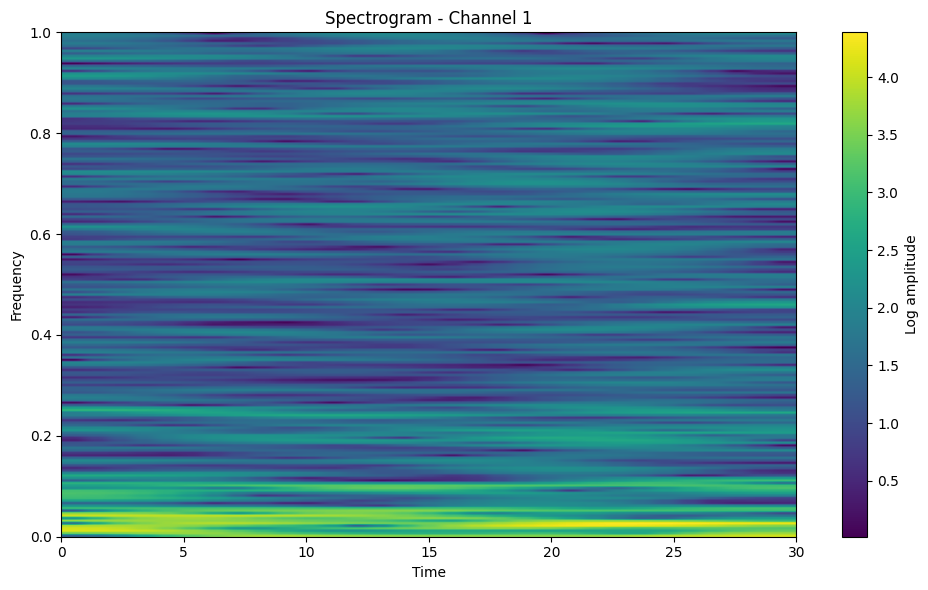

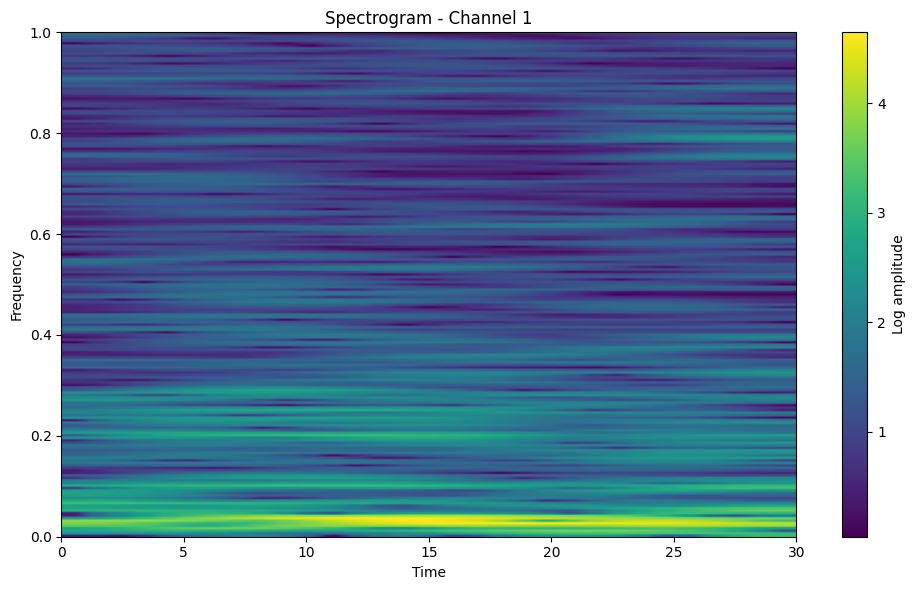

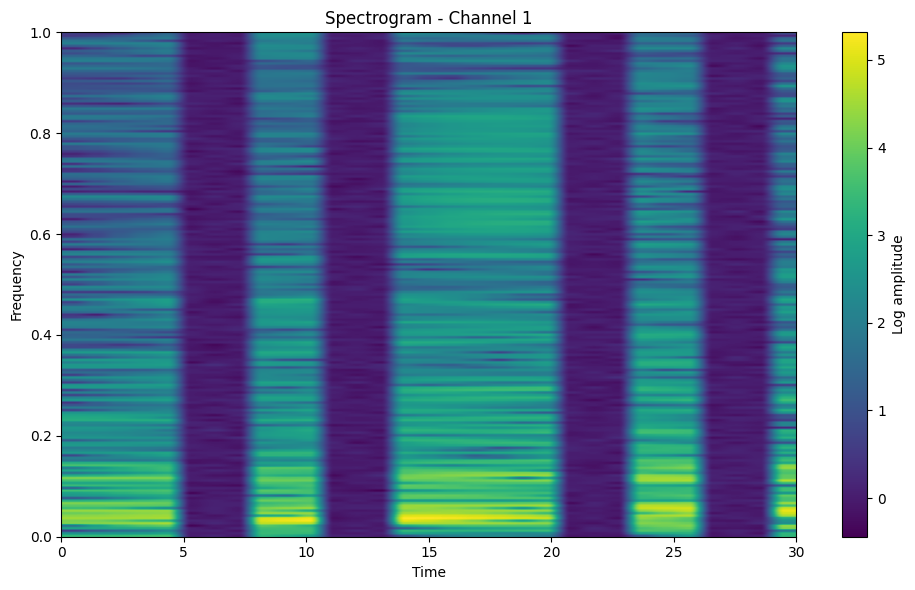

In [86]:
for i in range(5):
    plot_spectrogram(mask[i, :, :].unsqueeze(0).to('cpu'))

In [90]:
inputs.shape

torch.Size([497, 201, 31])